# Play with Mbs and Bandpasses

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide
import fixpythonpath

In [2]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


To use the IMO bundled in `litebird_sim`, one needs to do the following:

In [3]:
start_time = 0.0
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
sim = lbs.Simulation(
    base_path="inputs",
    imo=imo,
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

Otherwise, if you want to install the IMO, follow the instructions [in the IMO documentation](https://litebird-sim.readthedocs.io/en/master/imo.html#configuring-the-imo). You can install the IMO with the command `python -m litebird_sim.install_imo` with the [schema.json](https://github.com/litebird/litebird_sim/tree/master/default_imo) in `litebird_sim` or with any other local copy. In this case, use the following:

In [4]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="inputs",
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

## One channel

In [5]:
# Initialize the channel
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

In [6]:
# Parameters of Mbs
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
)

In [7]:
# Create the class and run the map generation
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
maps = mbs.run_all()[0]

[2024-04-08 15:05:42,955 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:05:42,957 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:05:42,970 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:42,970 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:42,970 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:43,052 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:05:43,053 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:43,054 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:43,054 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:43,127 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:05:43,129 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:43,129 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:43,129 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:44,389 INFO MPI#0000] Sigma is 13.079556 arc

In [8]:
maps.keys()

dict_keys(['M1-140', 'Coordinates', 'Mbs_parameters'])

In [9]:
# numpy array with the healpix map
maps["M1-140"].shape

(3, 49152)

In [10]:
# Coordinates of the simulated maps
maps["Coordinates"]

<CoordinateSystem.Galactic: 2>

In [11]:
# Parameters of the Mbs simulations
maps["Mbs_parameters"]

MbsParameters(nside=64, save=False, gaussian_smooth=True, bandpass_int=False, coadd=True, parallel_mc=False, make_noise=False, nmc_noise=1, seed_noise=None, n_split=False, make_cmb=False, cmb_ps_file='', cmb_r=0.0, nmc_cmb=1, seed_cmb=None, make_fg=True, fg_models={'pysm_synch_0': 'pysm_synch_0', 'pysm_freefree_1': 'pysm_freefree_1', 'pysm_dust_0': 'pysm_dust_0'}, make_dipole=False, sun_velocity=None, output_string='date_240408', units='K_CMB', maps_in_ecliptic=False)

## Many channels

In [12]:
# Obtain the info about the instrument from the imo
instrument = lbs.InstrumentInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/instrument_info", imo=imo
)

In [13]:
# Create a list with all the channels
channels = list()
for ch in instrument.channel_names:
    print(ch)
    channels.append(
        lbs.FreqChannelInfo.from_imo(
            url="/releases/vPTEP/satellite/MFT/" + ch + "/channel_info", imo=imo
        )
    )

M1-100
M2-119
M1-140
M2-166
M1-195


In [14]:
# Same as before but using the uuids
channels = list()
for uuid in instrument.channel_objs:
    channel = lbs.FreqChannelInfo.from_imo(url=uuid, imo=imo)
    print(channel.channel)
    channels.append(channel)

M1-100
M2-119
M1-140
M2-166
M1-195


In [15]:
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channels,
)
maps = mbs.run_all()[0]

[2024-04-08 15:05:46,432 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:05:46,432 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:05:46,434 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:46,434 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:46,434 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:46,511 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:05:46,512 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:46,513 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:46,513 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:46,587 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:05:46,589 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:46,589 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:46,589 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:46,707 INFO MPI#0000] Sigma is 16.052182 arc

In [16]:
for k in maps.keys():
    print(k)

M1-100
M2-119
M1-140
M2-166
M1-195
Coordinates
Mbs_parameters


## Some detectors

In [17]:
# Now we create a list of detectors
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)
wafer = "M02"
orient = "Q"
dets = []
for uuid in channel.detector_objs:
    det = lbs.DetectorInfo.from_imo(url=uuid, imo=imo)
    if (det.wafer == wafer) and (det.orient == orient):
        dets.append(det)

In [18]:
# We run as before but with detector_list instead of channel_list
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

[2024-04-08 15:05:48,182 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:05:48,183 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:05:48,184 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:48,184 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:48,184 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:48,257 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:05:48,259 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:48,259 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:48,259 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:48,337 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:05:48,338 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:05:48,338 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:05:48,338 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:05:48,453 INFO MPI#0000] Sigma is 13.079556 arc

[2024-04-08 15:05:50,677 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:50,677 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:50,763 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:50,764 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:50,765 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:50,765 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:50,867 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:50,868 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:50,868 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:50,869 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:50,952 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:50,952 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:50,953 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:50,954 

[2024-04-08 15:05:53,403 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:53,405 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:53,407 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:53,408 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:53,515 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:53,521 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:53,524 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:53,525 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:53,638 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:53,638 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:53,644 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:53,645 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:53,746 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:53,747

[2024-04-08 15:05:56,141 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:56,247 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:56,248 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:56,249 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:56,249 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:56,340 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:56,340 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:56,341 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:56,347 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:56,430 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:56,431 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:56,431 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:56,432 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:56,539 INFO MPI#0000]

[2024-04-08 15:05:58,997 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:59,000 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:59,001 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:59,108 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:59,113 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:59,116 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:59,117 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:59,221 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:59,222 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:59,225 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:05:59,226 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:05:59,324 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:05:59,330 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:05:59,333 INFO MPI#0000

[2024-04-08 15:06:01,721 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:01,826 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:01,827 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:01,830 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:01,831 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:01,918 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:01,918 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:01,919 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:01,919 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:02,014 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:02,014 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:02,016 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:02,016 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:02,105 INFO MPI#0000]

[2024-04-08 15:06:04,406 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:04,412 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:04,509 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:04,509 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:04,510 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:04,518 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:04,622 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:04,623 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:04,625 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:04,627 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:04,733 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:04,735 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:04,736 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:04,737 

[2024-04-08 15:06:07,174 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:07,174 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:07,175 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:07,175 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:07,272 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:07,272 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:07,273 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:07,274 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:07,367 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:07,369 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-04-08 15:06:07,371 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:06:07,372 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:06:07,465 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-04-08 15:06:07,467

In [19]:
for k in maps.keys():
    print(k)

001_002_030_00A_140_T
001_002_030_00A_140_B
001_002_031_15B_140_T
001_002_031_00B_140_B
001_002_022_15A_140_T
001_002_022_00A_140_B
001_002_039_15A_140_T
001_002_039_00A_140_B
001_002_023_15B_140_T
001_002_023_00B_140_B
001_002_015_15A_140_T
001_002_015_00A_140_B
001_002_047_15A_140_T
001_002_047_00A_140_B
001_002_040_15B_140_T
001_002_040_00B_140_B
001_002_016_15B_140_T
001_002_016_00B_140_B
001_002_009_15A_140_T
001_002_009_00A_140_B
001_002_006_30B_140_T
001_002_006_00B_140_B
001_002_012_30B_140_T
001_002_012_00B_140_B
001_002_019_30B_140_T
001_002_019_00B_140_B
001_002_027_30B_140_T
001_002_027_00B_140_B
001_002_036_30B_140_T
001_002_036_00B_140_B
001_002_044_15B_140_T
001_002_044_00B_140_B
001_002_051_15B_140_T
001_002_051_00B_140_B
001_002_054_15A_140_T
001_002_054_00A_140_B
001_002_048_15B_140_T
001_002_048_00B_140_B
001_002_034_15A_140_T
001_002_034_00A_140_B
001_002_010_15B_140_T
001_002_010_00B_140_B
001_002_004_15A_140_T
001_002_004_00A_140_B
001_002_001_30B_140_T
001_002_00

## Now integrating over a top-hat bandpass

In [20]:
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

In [21]:
# We generate maps with an without band integration
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsnoint = mbs.run_all()[0]

params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsint = mbs.run_all()[0]

[2024-04-08 15:06:09,396 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:06:09,397 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:06:09,399 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:09,399 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:09,399 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:09,487 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:06:09,488 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:09,489 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:09,489 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:09,568 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:06:09,569 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:09,570 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:09,570 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:09,684 INFO MPI#0000] Sigma is 13.079556 arc

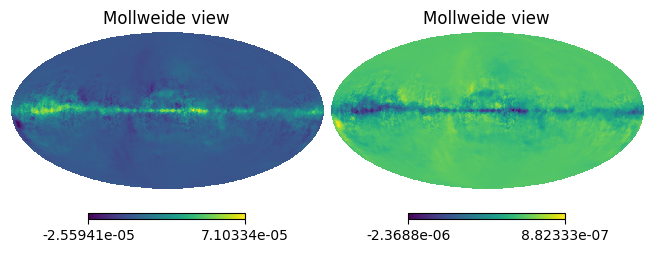

In [22]:
hp.mollview(mapsint["M1-140"][1], sub=121)
hp.mollview((mapsnoint["M1-140"] - mapsint["M1-140"])[1], sub=122)

## Now with a customized bandpass

Text(0, 0.5, 'Transmission')

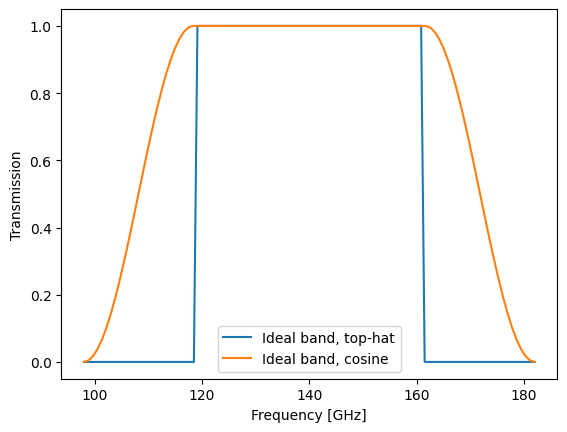

In [23]:
# We change the shape of the bands, in channel1 top-hat in channel2 top-hat with cosine tails

channel1 = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

band = lbs.BandPassInfo(
    bandcenter_ghz=channel1.bandcenter_ghz,
    bandwidth_ghz=channel1.bandwidth_ghz,
    bandtype="top-hat-cosine",
    nsamples_inband=100,
)
channel2 = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)
channel2.band = band

plt.plot(channel1.band.freqs_ghz, channel1.band.weights, label="Ideal band, top-hat")
plt.plot(channel2.band.freqs_ghz, channel2.band.weights, label="Ideal band, cosine")
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Transmission')

In [24]:
# Here we do the comparison
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel1,
)
mapsth = mbs.run_all()[0]

mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel2,
)
mapsthc = mbs.run_all()[0]

[2024-04-08 15:06:11,324 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:06:11,325 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:06:11,326 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:11,327 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:11,327 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:11,412 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:06:11,414 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:11,415 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:11,415 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:11,496 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:06:11,498 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:11,498 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:11,498 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:11,597 INFO MPI#0000] Removing 64/128 points

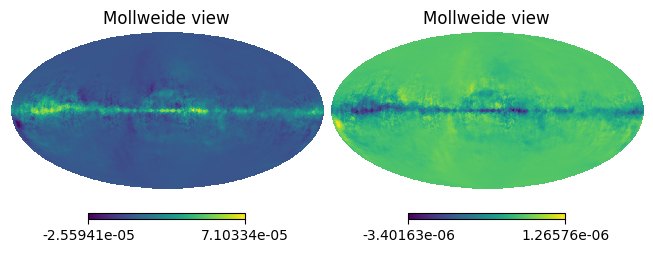

In [25]:
hp.mollview(mapsth["M1-140"][1], sub=121)
hp.mollview((mapsth["M1-140"] - mapsthc["M1-140"])[1], sub=122)

## Scan the sky

In [26]:
# Now we do a simple simulation of 1 hour with 4 detectors
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_004_060_30A_140_T",
    "001_003_000_00A_140_B",
    "001_003_001_00B_140_T",
    "001_003_002_45A_140_B",
]

In [27]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./inputs",
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band


/home/serenagiardiello/lbs/litebird_sim/litebird_sim/bandpasses.py:271: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]
/home/serenagiardiello/lbs/litebird_sim/litebird_sim/bandpasses.py:271: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


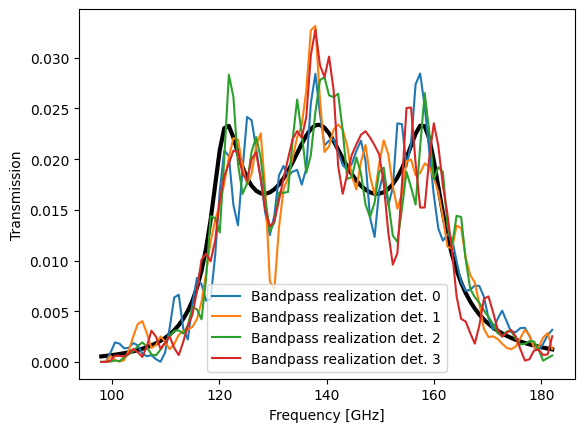

In [28]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/vPTEP/satellite/{telescope}/instrument_info",
    )
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    imo, f"/releases/vPTEP/satellite/{telescope}/{channel}/channel_info"
)

band = lbs.BandPassInfo(
    bandcenter_ghz=channelinfo.bandcenter_ghz,
    bandwidth_ghz=channelinfo.bandwidth_ghz,
    bandtype="cheby",
    nsamples_inband=100,
    normalize=True,
)

plt.plot(band.freqs_ghz, band.weights, lw=3, color="k")

dets = []
for i,namedet in enumerate(detlist):
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/vPTEP/satellite/{telescope}/{channel}/{namedet}/detector_info",
        imo=imo,
    )
    det.quat = [0.0, 0.0, 0.0, 1.0]
    det.band = band
    det.fwhm_arcmin *= np.random.normal(1.0, 0.01)
    det.band.weights = band.bandpass_resampling()
    dets.append(det)
    plt.plot(band.freqs_ghz, det.band.weights, label = f'Bandpass realization det. {i}')
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Transmission')
    plt.legend()

In [29]:
sim.set_scanning_strategy(imo_url=f"/releases/vPTEP/satellite/scanning_parameters/")

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

In [30]:
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

[2024-04-08 15:06:15,502 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:06:15,503 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:06:15,505 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:15,506 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:15,506 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:15,590 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:06:15,591 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:15,592 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:15,592 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:15,672 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:06:15,673 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:06:15,673 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:06:15,674 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:06:15,767 INFO MPI#0000] Removing 98/100 points

In [31]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),
)
sim.compute_pointings()

In [32]:
sim.fill_tods(maps)

In [33]:
maps.keys()

dict_keys(['001_004_060_30A_140_T', '001_003_000_00A_140_B', '001_003_001_00B_140_T', '001_003_002_45A_140_B', 'Coordinates', 'Mbs_parameters'])

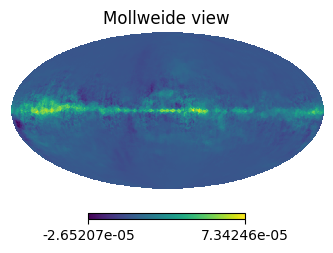

In [34]:
hp.mollview(maps["001_004_060_30A_140_T"][1], sub=121) 
#This map is slightly different from the previous ones due to the different bandpass

Text(0, 0.5, 'Signal [K]')

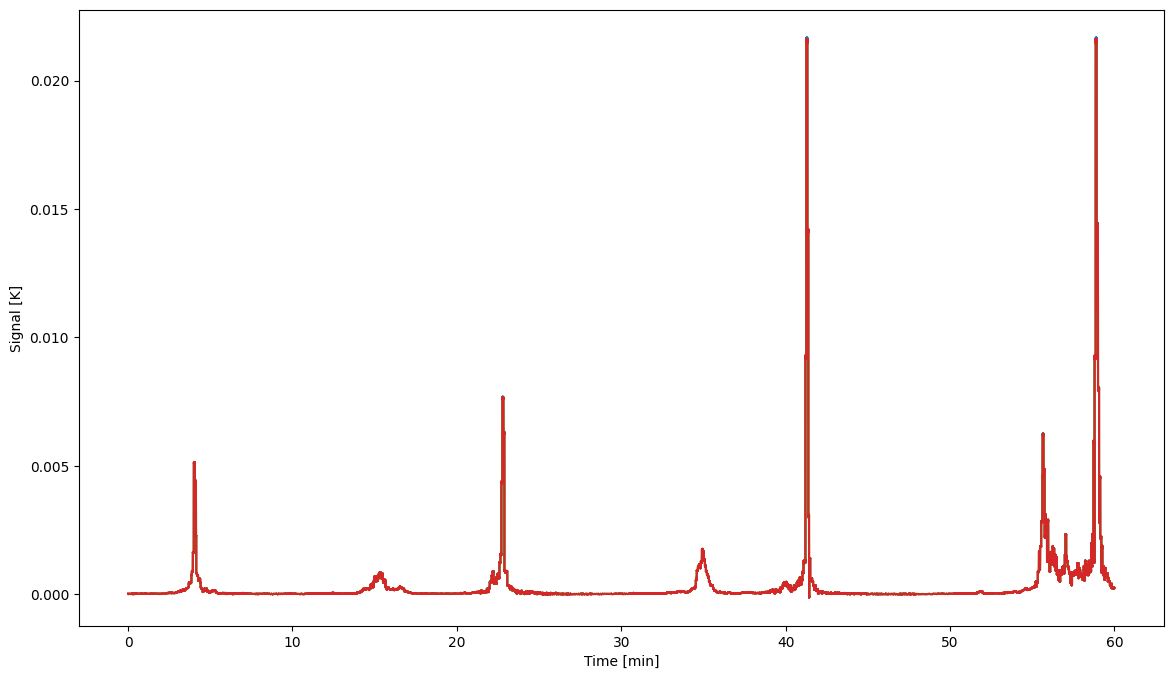

In [35]:
times_min = (sim.observations[0].get_times() - sim.observations[0].start_time) / 60.0
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1])
plt.plot(times_min, sim.observations[0].tod[2])
plt.plot(times_min, sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

Text(0, 0.5, '$\\Delta$ Signal [K]')

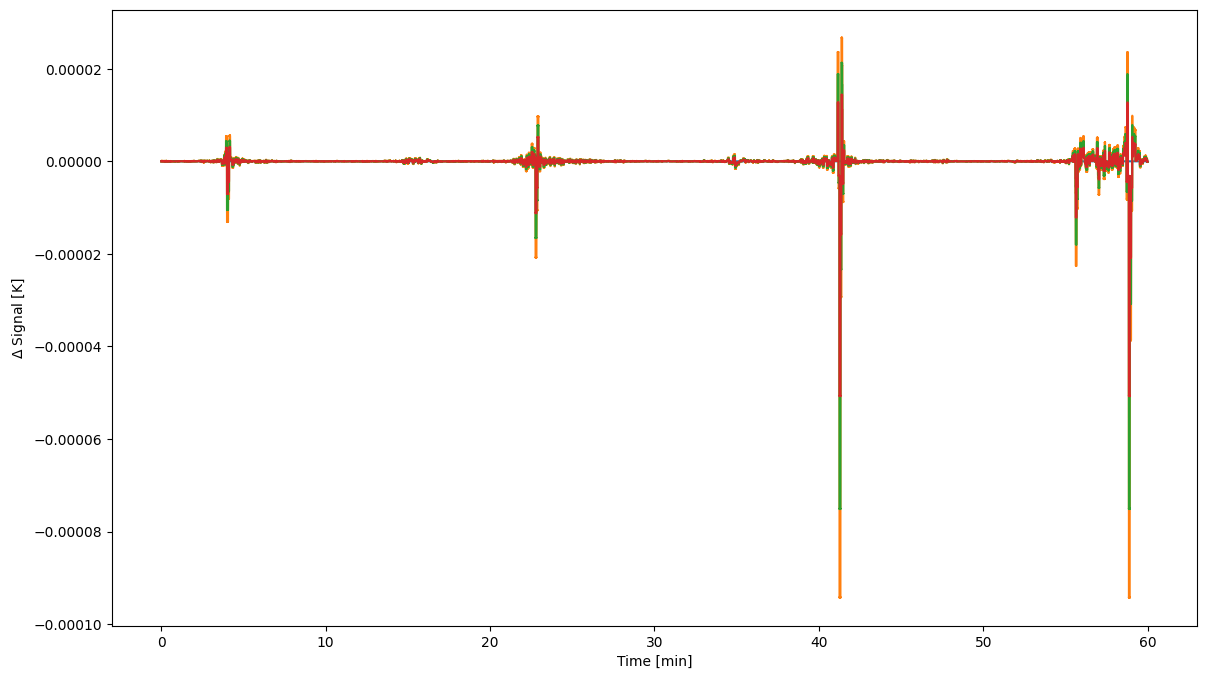

In [36]:
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[2] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[3] - sim.observations[0].tod[0])

plt.xlabel("Time [min]")
plt.ylabel(r"$\Delta$ Signal [K]")